# Dog Image Classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [6]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [7]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.  
We will be using dog classification dataset as example in this project. First of all, we will need to download the data online, and unzip the images. There are three folders consisted here: `test`, `train`, and `valid`. Within each folder, there are 133 folders, where each consists examples of conrresponding dog breed.

In [20]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-07-15 08:19:44--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.24
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  46.8MB/s    in 45s     

2022-07-15 08:20:31 (24.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [8]:
# upload images to s3 bucket
BUCKET = "sagemaker-studio-g0jvojqtzd9"
PREFIX = "dogImages"

sagemaker_session = sagemaker.Session()
# upload_inputs = sagemaker_session.upload_data(path="dogImages", bucket=BUCKET, key_prefix=PREFIX)
# upload_inputs = "s3://sagemaker-studio-g0jvojqtzd9/dogImages/"

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
#TODO: Declare your HP ranges, metrics etc.
# we will need to import some packages to make tuning work
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(3, 5)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [10]:
#TODO: Create estimators for your HPs
# Import PyTorch, and create estimator along with some parameters such as instance type
from sagemaker.pytorch import PyTorch

ROLE = sagemaker.get_execution_role()

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=ROLE,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [7]:
# TODO: Fit your HP Tuner
import os
os.environ['SM_MODEL_DIR']='s3://sagemaker-studio-g0jvojqtzd9/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-studio-g0jvojqtzd9/output/'
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-studio-g0jvojqtzd9/'
# os.environ['SM_CHANNEL_GPU']="1"
tuner.fit({"training": "s3://sagemaker-studio-g0jvojqtzd9/"}, wait=False) # TODO: Remember to include your data channels
# tuner.best_training_job()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [14]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220715-2343')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""256""",3.0,0.043411,pytorch-training-220715-2343-004-2feb2471,Completed,None,2022-07-16 00:59:41+00:00,2022-07-16 01:46:59+00:00,2838.0
1,"""256""",5.0,0.065366,pytorch-training-220715-2343-003-717b3c57,Completed,None,2022-07-16 00:35:24+00:00,2022-07-16 01:52:01+00:00,4597.0
2,"""128""",3.0,0.046618,pytorch-training-220715-2343-002-b7bd0328,Completed,None,2022-07-15 23:44:51+00:00,2022-07-16 00:31:25+00:00,2794.0
3,"""64""",5.0,0.045787,pytorch-training-220715-2343-001-db06b3e9,Completed,None,2022-07-15 23:44:52+00:00,2022-07-16 00:57:06+00:00,4334.0


In [15]:
# kernel died, but but comparing training jobs, this is the best so far
BetterTrainingJobName='pytorch-training-220716-0841-002-a0f41645'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
best_estimator=my_estimator
my_estimator.hyperparameters()


2022-07-16 11:39:48 Starting - Preparing the instances for training
2022-07-16 11:39:48 Downloading - Downloading input data
2022-07-16 11:39:48 Training - Training image download completed. Training in progress.
2022-07-16 11:39:48 Uploading - Uploading generated training model
2022-07-16 11:39:48 Completed - Training job completed


{'_tuning_objective_metric': 'average test loss',
 'batch_size': '"256"',
 'epochs': '4',
 'lr': '0.0010838876736693989',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-07-16-08-41-44-822"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-242223641680/pytorch-training-2022-07-16-08-41-44-822/source/sourcedir.tar.gz"'}

In [10]:
# TODO: Get the best estimators and the best HPs

# best_estimator=tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
# best_estimator.hyperparameters()

In [14]:
# listing the best hyperparameters
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr'], \
                   "epochs": best_estimator.hyperparameters()['epochs']}
hyperparameters

{'batch_size': 256, 'lr': '0.0010838876736693989', 'epochs': '4'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [21]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

RULES = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [29]:
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point='train_model.py',
    role=ROLE,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = RULES,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

estimator.fit({"training": "s3://sagemaker-studio-g0jvojqtzd9/"}, wait=False)

## Plotting training performance

In [17]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

# kernel died, but but comparing training jobs, this is the best so far
TrainingJobName='pytorch-training-2022-07-17-16-55-19-402'
estimator = sagemaker.estimator.Estimator.attach(TrainingJobName)

trial = create_trial("s3://sagemaker-us-east-1-242223641680/pytorch-training-2022-07-17-16-55-19-402/debug-output/")


2022-07-17 18:25:09 Starting - Preparing the instances for training
2022-07-17 18:25:09 Downloading - Downloading input data
2022-07-17 18:25:09 Training - Training image download completed. Training in progress.
2022-07-17 18:25:09 Uploading - Uploading generated training model
2022-07-17 18:25:09 Completed - Training job completed
[2022-07-17 18:38:47.028 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:501 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-242223641680/pytorch-training-2022-07-17-16-55-19-402/debug-output/


In [25]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [31]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

2

In [29]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

1

In [21]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


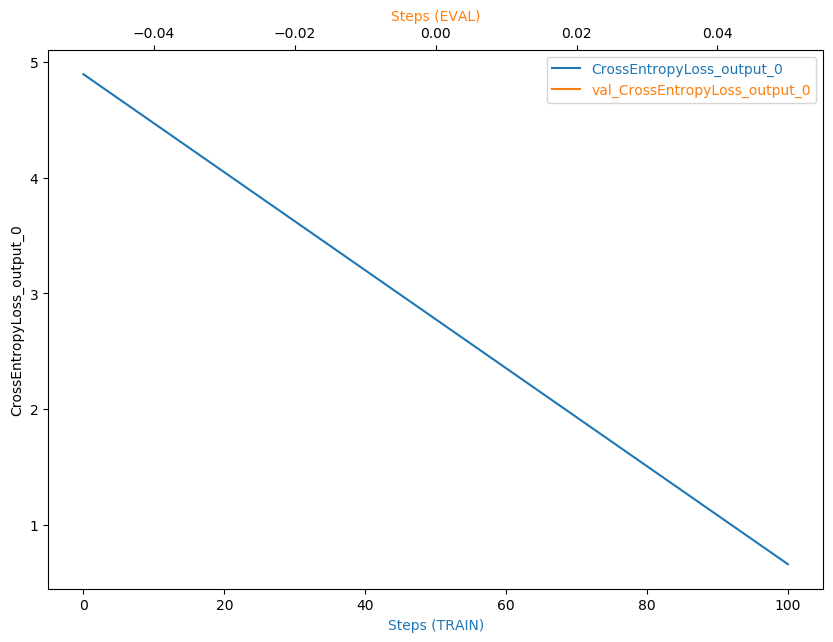

In [24]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
    Yes, there is anomalous behaviour in my debugging output. The problem is that there are only two output for my loss function. It is not necessarily an error, but rather inssuficient steps in my debugger parameters to generate enought points for graph. When I was referring back to the code in debugger section, I directly copied the save_interval as 100 and 10. At time, I thought this is the interval for time, but instead, it is for how many iterations. Because the reference code uses 32 batch size, but my hyperparameter turning returned 256 batch size, I essentially does not have much points for loss function output. I need only have a smaller save_interval for debugger hyperparameter.
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Displaying profiler output

In [32]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [33]:
! aws s3 ls {rule_output_path} --recursive

2022-07-17 18:24:28     329717 pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-17 18:24:27     171080 pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-17 18:24:23        193 pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-17 18:24:23        201 pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-17 18:24:23        126 pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-07-17 18:24:23        127 pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-17 18:24:24        200 pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-re

In [34]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-242223641680/pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-242223641680/pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-242223641680/pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-242223641680/pytorch-training-2022-07-17-16-55-19-402/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-242223641680/

In [35]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [36]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [42]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge') # TODO: Add your deployment configuration like instance type and number of instances

-----

KeyboardInterrupt: 

In [ ]:
# TODO: Run an prediction on the endpoint

# TODO: Your code to load and preprocess image to send to endpoint for prediction
image={ "url": "https://s3://sagemaker-studio-g0jvojqtzd9/dogImages/test/059.Doberman_pinscher/Doberman_pinscher_04194.jpg" }

In [ ]:
import json
# response = predictor.predict(image)

response=predictor.predict(json.dumps(image), initial_args={"ContentType": "application/json"})

In [ ]:
type(response[0][0])

In [ ]:
response[0]

In [ ]:
import numpy as np
np.argmax(response, 1)

In [39]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

NameError: name 'predictor' is not defined

In [52]:
dir(estimator)
ROLE

'arn:aws:iam::242223641680:role/service-role/AmazonSageMaker-ExecutionRole-20220711T140527'